In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import itertools
import lightgbm as lgbm
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

import matplotlib.pyplot as plt

from script import *
from feature_engineering import *
import db_operations as dbop
from constants import *
import data_process as dp

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
pd.set_option('display.max_rows',200)
idx = pd.IndexSlice
agg_operations =['mean','median','max','min','std','size']

In [3]:
%time df = pd.read_hdf(os.path.join('datasets','df_20140101.h5'),key='data')
df = df.sort_index()
df.shape
df.columns

Wall time: 4.53 s


(4593560, 64)

Index(['open', 'high', 'low', 'close', 'vol', 'amt', 'adj_factor', 'avg',
       'close0', 'avg0', 'pct', 'turnover_rate', 'turnover_rate_f',
       'volume_ratio', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv', 'pb*pe_ttm',
       'pb*pe', '5ma', '10ma', '20ma', '40ma', '60ma', '120ma', '250ma',
       'close/5ma', 'close/10ma', 'close/20ma', 'close/40ma', 'close/60ma',
       'close/120ma', 'close/250ma', '60ma_pct', '20ma_pct', 'p5max_abs_pct',
       'p10max_abs_pct', '30ma', '30ma_pct', 'close/30ma', 'prev_close',
       'day_pct', 'close0_rank', 'close0_pct', 'prev_pct', 'prev_day_pct',
       'sell_at', 'sell_at0', 'sell_date', 'sell_idx', 'buy_at', 'buy_at0',
       'max', 'max_idx', 'idx', 'is_selled', 'r'],
      dtype='object')

In [4]:
mask_date = df.index.get_level_values('date')>='2016-01-01'

In [ ]:
%time df['5ma_pct'] = df['5ma'].sort_index().groupby('code').pct_change()*100 # 7s

target_col = '5ma_pct'
min_periods=1

for k in [5,10,15,20,25,30]:
    %time tmp = groupby_rolling(df[[target_col]],level="code",window=k,ops=['mean','median','std'],min_periods=min_periods)
    df[tmp.columns] = tmp

for k in [5,10,15,20,25,30]:
#     %time tmp = groupby_rolling(df[[target_col,'close']],level="code",window=k,ops=['mean','median','std'],min_periods=min_periods)
#     df[tmp.columns] = tmp
    df['p{}mean-std_5ma_pct'.format(k)] = df['p{}mean_5ma_pct'.format(k)]-df['p{}std_5ma_pct'.format(k)]
    
list(df.columns)

Wall time: 6.02 s
Wall time: 11.6 s
Wall time: 9.69 s
Wall time: 9.71 s
Wall time: 10.5 s


In [ ]:
%time df_tmp = df[mask_date] # 4s

quantiles = [0.5,0.8,0.9,0.95,0.99]
df_quantile = pd.DataFrame(columns=quantiles)

for k in [5,10,15,20,25,30]:
#     print('\nk={}'.format(k))
    for p in quantiles:
        col1 = 'p{}mean_5ma_pct'.format(k)
        col2 = 'p{}mean-std_5ma_pct'.format(k)
        df_quantile.loc[col1,p] = df[col1].quantile(p)
        df_quantile.loc[col2,p] = df[col2].quantile(p)
#         '{}:{:.1%}={:.3f}'.format(col1,p,df[col1].quantile(p))
#         '{}:{:.1%}={:.3f}'.format(col2,p,df[col2].quantile(p))

df_quantile

In [ ]:
%time date = df.index.get_level_values('date').drop_duplicates()
len(date)
date_idx = pd.Series(np.arange(len(date)),index=date,name='date_idx')
date_idx.head()

In [ ]:
%time df = df.join(date_idx,on='date',how='left') #5.84s
df.head()
df.columns

In [ ]:
df['f1_open'] = df['open'].sort_index().groupby('code').shift(-1)
df['f2_close'] = df['close'].sort_index().groupby('code').shift(-2)
df['f2_open'] = df['open'].sort_index().groupby('code').shift(-2)

%time df['r_t2'] = df['f2_close']/df['f1_open']-1
%time df['r_t1'] = df['f2_open']/df['f1_open']-1

df[['open','close','f1_open','f2_open','f2_close']].tail(5)

In [ ]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r']

features = [col for col in df.columns 
            if col not in ['date_idx','r_t1','r_t2']+ ['f1_open','f2_close','f2_open','sell_at0','sell_idx','buy_at0']+r_columns 
            and is_numeric_dtype(df.dtypes[col])]

features

In [13]:
mask_trend = [
    df['p15mean-std_5ma_pct'] > 0.15,
]

mask_low_pos = [

    df['close/60ma']<1.2,
#     df['close/60ma']<1.125,

#     df['close/30ma']<1.05, 
    df['close/5ma']<1.1,
    df['close/10ma']<1.1,

    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic


for m in masks:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

df_sample = df[mask_final]
df_sample.shape

(199754, 4593560, 0.0435, 0.0435)

(3556357, 4593560, 0.7742, 0.0208)

(4473030, 4593560, 0.9738, 0.0208)

(4301818, 4593560, 0.9365, 0.0203)

(4110067, 4593560, 0.8947, 0.0203)

(1056950, 4593560, 0.2301, 0.0055)

(4348257, 4593560, 0.9466, 0.0049)

(2056374, 4593560, 0.4477, 0.0043)

(1433930, 4593560, 0.3122, 0.0034)

(4580262, 4593560, 0.9971, 0.0034)

(15533, 95)

In [28]:
train_end_idx = 250 *2-1
train_period = 10

ycols = ['r_t1','r_t2']
ycol = 'r_t2'

cnt=0
y_pred_list = []
while train_end_idx+2<=date_idx.max():
    
    mask_train_date = df_sample['date_idx']<=train_end_idx
    mask_y = df_sample[ycol].notnull()
    mask_train = mask_train_date & mask_y
    
    mask_test = (df_sample['date_idx']>=train_end_idx+2) & (df_sample['date_idx']<train_end_idx+12)
    
    X_train,y_train = df_sample.loc[mask_train,features].fillna(-9999),df_sample.loc[mask_train,ycol]
    X_test,y_test = df_sample.loc[mask_test,features].fillna(-9999),df_sample.loc[mask_test,ycol]
    
    sample_weight = pd.Series(1,index=X_train.index)
    mask_weight = df_sample.loc[mask_train,'date_idx']>train_end_idx-125
    sample_weight.loc[mask_weight]+= (df_sample.loc[mask_train,'date_idx']-train_end_idx+125)/125*4
    
    if len(X_test)==0:
        print(train_end_idx,X_train.shape,y_train.shape,X_test.shape,y_test.shape)
        train_end_idx+=train_period
#         cnt +=1
        continue

    
        

    reg = DecisionTreeRegressor(max_depth=10,min_samples_leaf=50, #max(50,len(X_train)//200),
                                min_weight_fraction_leaf = 0.005,
                                max_leaf_nodes=12,
                                min_impurity_decrease=3.5e-6,
                                random_state=0)
    _ = reg.fit(X_train,y_train,sample_weight=sample_weight.values)
#     pd.DataFrame(reg.predict(X_test),index = X_test.index,columns=['pred'])
    y_pred_list.append(pd.DataFrame(reg.predict(X_test),index = X_test.index,columns=['pred']))
    
    if cnt%10==0:
        print(train_end_idx,X_train.shape,y_train.shape,X_test.shape,y_test.shape)
        importance = pd.Series(reg.feature_importances_,index=features).sort_values(ascending=False)
        importance[importance>0]
    
    train_end_idx+=train_period
    cnt +=1
#     break
    

499 (4054, 78) (4054,) (0, 78) (0,)
509 (4054, 78) (4054,) (20, 78) (20,)


day_pct            0.376171
close/120ma        0.226380
close/5ma          0.084309
prev_day_pct       0.073146
p5mean_5ma_pct     0.064295
turnover_rate_f    0.055891
pe_ttm             0.049304
close/20ma         0.041713
20ma_pct           0.028791
dtype: float64

609 (4780, 78) (4780,) (482, 78) (482,)


close/5ma          0.298987
p30std_5ma_pct     0.175668
60ma_pct           0.104801
pct                0.098936
turnover_rate_f    0.080896
prev_day_pct       0.055673
prev_pct           0.053011
p30mean_5ma_pct    0.048261
p25mean_5ma_pct    0.042841
close/10ma         0.040927
dtype: float64

709 (5884, 78) (5884,) (38, 78) (38,)


pct                    0.318735
close/250ma            0.118323
close/20ma             0.084683
turnover_rate_f        0.081522
close/5ma              0.067271
free_share             0.064449
pb*pe                  0.059352
p30mean-std_5ma_pct    0.058598
p20median_5ma_pct      0.056740
volume_ratio           0.049698
p10std_5ma_pct         0.040630
dtype: float64

809 (6646, 78) (6646,) (20, 78) (20,)


pct                    0.368869
close/120ma            0.156502
close/5ma              0.105059
close/20ma             0.064570
p30mean_5ma_pct        0.062026
close0_pct             0.059884
prev_day_pct           0.051882
p30mean-std_5ma_pct    0.047074
turnover_rate          0.045063
volume_ratio           0.039071
dtype: float64

909 (7758, 78) (7758,) (98, 78) (98,)


pct                    0.315445
close/10ma             0.121189
close/60ma             0.108746
p30std_5ma_pct         0.088417
volume_ratio           0.072802
p30mean_5ma_pct        0.067108
turnover_rate_f        0.063029
p30mean-std_5ma_pct    0.056141
pb*pe_ttm              0.055585
prev_pct               0.051539
dtype: float64

1009 (8834, 78) (8834,) (220, 78) (220,)


pct                    0.294231
prev_day_pct           0.176389
p30mean-std_5ma_pct    0.139834
p25std_5ma_pct         0.106199
5ma_pct                0.070278
close/5ma              0.067337
p30mean_5ma_pct        0.063191
close/120ma            0.042161
turnover_rate_f        0.040379
dtype: float64

1109 (9818, 78) (9818,) (61, 78) (61,)


pct                  0.306564
close/5ma            0.130677
p30std_5ma_pct       0.120344
turnover_rate_f      0.087004
p10median_5ma_pct    0.070485
p30mean_5ma_pct      0.069408
60ma_pct             0.066537
prev_pct             0.061319
close0               0.048575
close/30ma           0.039087
dtype: float64

1209 (10139, 78) (10139,) (5, 78) (5,)


pct                    0.295613
p30std_5ma_pct         0.126464
close/5ma              0.115769
prev_pct               0.074121
turnover_rate_f        0.073049
p30mean-std_5ma_pct    0.068701
prev_day_pct           0.068107
60ma_pct               0.052817
p30mean_5ma_pct        0.045216
close0_pct             0.042719
p10mean-std_5ma_pct    0.037422
dtype: float64

1299 (12308, 78) (12308,) (0, 78) (0,)
1319 (12334, 78) (12334,) (46, 78) (46,)


pct                    0.375632
5ma_pct                0.120161
p30mean-std_5ma_pct    0.111786
volume_ratio           0.076885
close/5ma              0.058718
prev_pct               0.057014
30ma_pct               0.055551
p5max_abs_pct          0.052798
avg0                   0.047095
p15mean-std_5ma_pct    0.044360
dtype: float64

1419 (13545, 78) (13545,) (41, 78) (41,)


pct                 0.375439
close/5ma           0.118337
turnover_rate_f     0.111193
p30std_5ma_pct      0.109089
prev_day_pct        0.092994
p30mean_5ma_pct     0.069186
close/30ma          0.042285
close/120ma         0.041018
p5median_5ma_pct    0.040459
dtype: float64

1519 (14853, 78) (14853,) (114, 78) (114,)


close/5ma              0.551758
pct                    0.093632
volume_ratio           0.055010
p20std_5ma_pct         0.049538
total_mv               0.048321
pb                     0.046726
p30mean-std_5ma_pct    0.042258
turnover_rate          0.041865
p30mean_5ma_pct        0.037684
float_share            0.033208
dtype: float64

In [29]:
y_pred = pd.concat(y_pred_list,axis=0)
y_pred['pred_rank'] = y_pred.groupby('date')['pred'].rank(ascending=False,method='min')
y_pred['pred_rank_pct'] = y_pred.groupby('date')['pred'].rank(ascending=False,pct=True)
y_pred.shape
y_pred.head()

Y = df.loc[mask_final&mask_date,ycols]


Y2 = Y.join(y_pred,how='left')
# res = Y2.groupby('pred').agg(['mean','median','max','min','size']).sort_index()
# res
# plt.bar(np.arange(len(res)),res[('r_t2','mean')])
# plt.show()
# plt.bar(np.arange(len(res)),res[('r_t1','mean')])


(11479, 3)

pred  pred_rank  pred_rank_pct
code      date                                          
000423.SZ 2016-02-23 -0.007975        2.0       1.000000
          2016-02-24 -0.007975        3.0       0.875000
000961.SZ 2016-02-16 -0.004577        2.0       1.000000
002007.SZ 2016-02-05 -0.007975        2.0       0.666667
002416.SZ 2016-02-04  0.000592        1.0       1.000000

In [30]:
tmp_day = Y2[(Y2['pred']>0.005) & (Y2['pred_rank']<=1)].groupby('date')[['r_t1','r_t2']].agg(['mean','median','size'])
tmp_day.shape
tmp_day.head()



day_r = tmp_day.reindex(date).fillna(0)

day_r.columns = ['_'.join(col) for col in day_r]
day_r['idx'] = np.arange(len(day_r))
day_r_t2_0=day_r[['r_t2_mean','r_t2_median']].add_suffix('_0')
day_r_t2_0.loc[day_r['idx']%2==0,:]=0

day_r_t2_1=day_r[['r_t2_mean','r_t2_median']].add_suffix('_1')
day_r_t2_1.loc[day_r['idx']%2==1,:]=0
# day_r.tail(50)
# day_r_t2_0.tail(50)
# day_r_t2_1.tail(50)

day_r = pd.concat([day_r,day_r_t2_0,day_r_t2_1],axis=1)
day_r.tail(5)

(693, 6)

r_t1                     r_t2               
                mean    median size      mean    median size
date                                                        
2016-02-16  0.155877  0.155877    1  0.200503  0.200503    1
2016-02-23  0.010666  0.010666    1 -0.085751 -0.085751    1
2016-02-24 -0.083580 -0.083580    1 -0.131279 -0.131279    1
2016-02-25  0.045987  0.045987    1  0.090301  0.090301    1
2016-02-29  0.034103  0.016667    3  0.098604  0.075000    3

,r_t1_mean,r_t1_median,r_t1_size,r_t2_mean,r_t2_median,r_t2_size,idx,r_t2_mean_0,r_t2_median_0,r_t2_mean_1,r_t2_median_1
date,,,,,,,,,,,
2020-05-26,-0.017742,-0.017742,2.0,-0.013730,-0.013730,2.0,1556,0.000000,0.000000,-0.01373,-0.01373
2020-05-27,0.002269,0.002269,1.0,0.023071,0.023071,1.0,1557,0.023071,0.023071,0.00000,0.00000
2020-05-28,0.000000,0.000000,1.0,0.000000,0.000000,1.0,1558,0.000000,0.000000,0.00000,0.00000
2020-05-29,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1559,0.000000,0.000000,0.00000,0.00000
2014-07-15,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1560,0.000000,0.000000,0.00000,0.00000


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1
date,,,,,,
2014-01-02,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-03,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-06,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-07,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-08,1.0,1.0,1.0,1.0,1.0,1.0


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-08,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Text(0.5,1,'val_r_t1_mean withdraw')

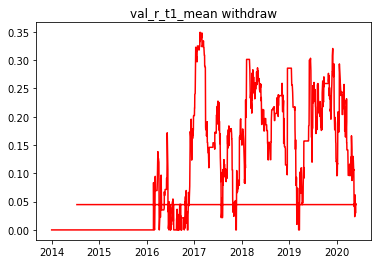

Text(0.5,1,'val_r_t1_median withdraw')

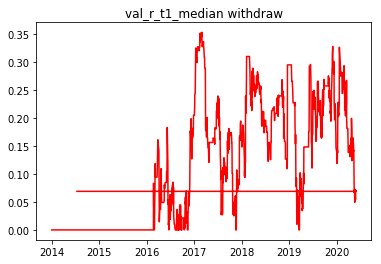

Text(0.5,1,'val_r_t2_mean_0 withdraw')

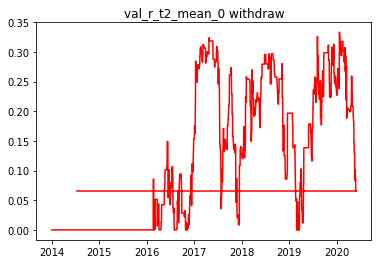

Text(0.5,1,'val_r_t2_median_0 withdraw')

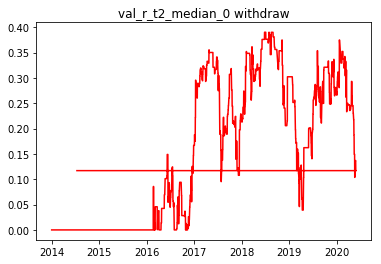

Text(0.5,1,'val_r_t2_mean_1 withdraw')

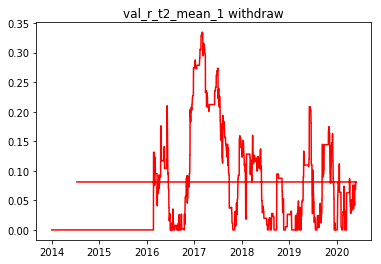

Text(0.5,1,'val_r_t2_median_1 withdraw')

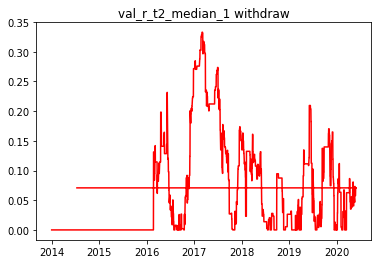

Text(0.5,1,'val_r_t2_mean withdraw')

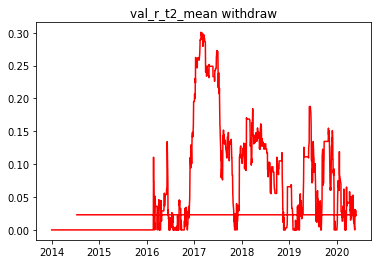

Text(0.5,1,'val_r_t2_median withdraw')

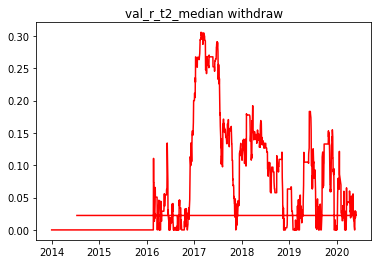

,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,...,cummax_val_r_t2_median_0,withdraw_val_r_t2_median_0,cummax_val_r_t2_mean_1,withdraw_val_r_t2_mean_1,cummax_val_r_t2_median_1,withdraw_val_r_t2_median_1,cummax_val_r_t2_mean,withdraw_val_r_t2_mean,cummax_val_r_t2_median,withdraw_val_r_t2_median
date,,,,,,,,,,,,,,,,,,,,,
2020-04-30,0.002030,0.002030,1.0,0.025667,0.025667,1.0,1.632451,1.384058,1.425232,1.178610,...,1.562202,0.245546,4.003356,0.033576,3.61264,0.038544,2.705592,0.021624,2.382585,0.023748
2020-05-06,-0.045853,-0.045853,1.0,-0.043830,-0.043830,1.0,1.557598,1.320595,1.425232,1.178610,...,1.562202,0.245546,4.003356,0.075934,3.61264,0.080684,2.705592,0.052962,2.382585,0.055696
2020-05-07,0.009299,0.009299,2.0,0.020115,0.020115,2.0,1.572082,1.332875,1.453902,1.202318,...,1.562202,0.230369,4.003356,0.075934,3.61264,0.080684,2.705592,0.047664,2.382585,0.050721
2020-05-08,-0.002079,-0.002079,1.0,0.043659,0.043659,1.0,1.568814,1.330104,1.453902,1.202318,...,1.562202,0.230369,4.003356,0.035590,3.61264,0.040548,2.705592,0.017816,2.382585,0.020292
2020-05-11,0.020833,0.020833,1.0,0.016667,0.016667,1.0,1.601498,1.357815,1.478133,1.222357,...,1.562202,0.217542,4.003356,0.035590,3.61264,0.040548,2.705592,0.013338,2.382585,0.016087
2020-05-12,-0.001423,-0.001423,2.0,-0.010899,-0.010899,2.0,1.599218,1.355882,1.478133,1.222357,...,1.562202,0.217542,4.003356,0.046101,3.61264,0.051005,2.705592,0.021115,2.382585,0.024015
2020-05-13,0.047307,0.047307,1.0,0.038574,0.038574,1.0,1.674873,1.420025,1.535150,1.269508,...,1.562202,0.187360,4.003356,0.046101,3.61264,0.051005,2.705592,0.010578,2.382585,0.014120
2020-05-14,0.019020,0.019020,2.0,-0.005270,-0.005270,2.0,1.706728,1.447033,1.535150,1.269508,...,1.562202,0.187360,4.003356,0.051129,3.61264,0.056006,2.705592,0.014297,2.382585,0.017912
2020-05-15,0.005567,0.019615,5.0,0.021535,0.046693,5.0,1.716230,1.475417,1.568209,1.328785,...,1.562202,0.149415,4.003356,0.051129,3.61264,0.056006,2.705592,0.008188,2.382585,0.005472


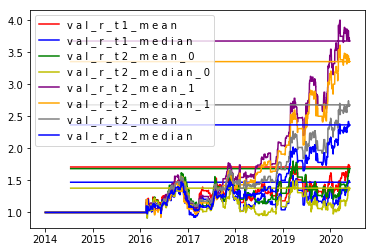


--------------------
M


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-05-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-07-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-08-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.009875,0.007999,0.005752,0.002771,0.017607,0.016602,0.012063,0.010351
median,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.089383,0.090732,0.078833,0.076703,0.070171,0.068917,0.062732,0.061429


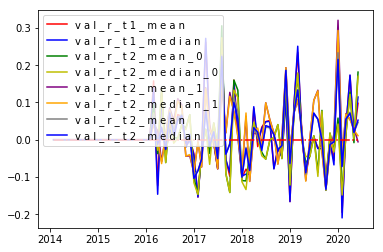


--------------------
Q


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-03-31,0.069780,0.023643,0.054116,0.041193,0.126326,0.101988,0.090221,0.071590


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.023291,0.017942,0.022504,0.014106,0.057061,0.054246,0.041092,0.036328
median,0.000000,0.000000,0.000000,0.000000,0.000799,0.000000,0.000000,0.000000
std,0.114171,0.113477,0.102274,0.098086,0.134026,0.130617,0.103160,0.098764


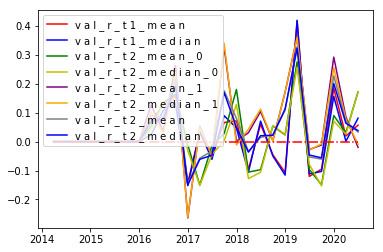


--------------------
A


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-12-31,0.252053,0.135732,0.368295,0.301463,0.150238,0.061802,0.259267,0.181632
2017-12-31,0.106100,0.091434,0.030272,-0.061389,0.328960,0.320626,0.166686,0.110248
2018-12-31,-0.147289,-0.160280,-0.078565,-0.107807,0.337583,0.362438,0.137929,0.143506
2019-12-31,0.330531,0.304028,0.060679,0.041899,0.691165,0.645289,0.446228,0.426108
2020-12-31,0.077661,0.082425,0.208712,0.202974,0.063845,0.067934,0.105452,0.104028


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.088437,0.064763,0.084199,0.053877,0.224542,0.208299,0.159366,0.137932
median,0.077661,0.082425,0.030272,0.000000,0.150238,0.067934,0.137929,0.110248
std,0.161770,0.142794,0.152942,0.146575,0.249533,0.243337,0.156250,0.144310


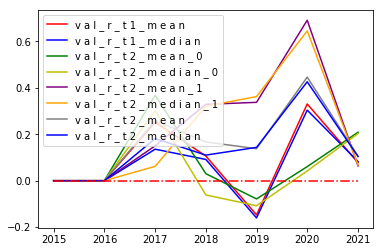

In [31]:
day_v = (day_r[['r_t1_mean','r_t1_median','r_t2_mean_0','r_t2_median_0','r_t2_mean_1','r_t2_median_1']]+1).cumprod().add_prefix('val_')
day_v.head()
day_v['val_r_t2_mean'] = (day_v['val_r_t2_mean_0']+day_v['val_r_t2_mean_1'])/2
day_v['val_r_t2_median'] = (day_v['val_r_t2_median_0']+day_v['val_r_t2_median_1'])/2
result_day = tmp_day.reindex(date).join(day_v,how='left')
result_day.head()
for col in day_v.columns:
    result_day['cummax_{}'.format(col)] = result_day[col].expanding().max() 
    result_day['withdraw_{}'.format(col)] = 1-result_day[col]/result_day['cummax_{}'.format(col)]
    plt.plot(result_day.index,result_day['withdraw_{}'.format(col)],color='r')
    plt.title('{} withdraw'.format(col))
    plt.show()

result_day.tail(20)


f= plt.figure()
for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
    _ = plt.plot(day_v.index,day_v[col],color=c,label=' '.join(col))
_ = plt.legend(loc='upper left')
plt.show()
# f.savefig('val_curve.png')



result_dict = {'day':result_day}

for key,p in zip(['month','quarter','year'],['M','Q','A']):
    result_period = result_day[day_v.columns].resample(p).apply(lambda x:x[-1]/x[0]-1)
    print('\n'+'-'*20+'\n'+p)
    result_dict[key] = result_period
    result_dict[key+'_stats'] = result_period.agg(['mean','median','std'])
    result_dict[key]
    result_dict[key+'_stats']
    
    for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
        _ = plt.plot(result_period.index,result_period[col],color=c,label=' '.join(col))
    _ = plt.legend(loc='upper left')
    _ = plt.plot(result_period.index,[0]*len(result_period),color='r',linestyle='-.')
    plt.show()

In [94]:
sample_weight = pd.Series(1,index=X_train.index)
sample_weight

code       date      
000001.SZ  2017-09-07    1
           2017-09-08    1
           2017-11-27    1
           2017-11-28    1
           2019-01-24    1
                        ..
603993.SH  2019-03-01    1
           2019-03-04    1
           2019-03-05    1
           2019-03-08    1
           2019-03-11    1
Length: 15399, dtype: int64

In [95]:
mask_weight = df_sample.loc[mask_train,'date_idx']>train_end_idx-125
sample_weight.loc[mask_weight]+= (df_sample.loc[mask_train,'date_idx']-train_end_idx+125)/125*4
sample_weight

code       date      
000001.SZ  2017-09-07    1.0
           2017-09-08    1.0
           2017-11-27    1.0
           2017-11-28    1.0
           2019-01-24    1.0
                        ... 
603993.SH  2019-03-01    1.0
           2019-03-04    1.0
           2019-03-05    1.0
           2019-03-08    1.0
           2019-03-11    1.0
Length: 15399, dtype: float64

In [97]:
sample_weight[sample_weight>1].sort_values()

code       date      
600673.SH  2019-11-22    1.032
000800.SZ  2019-11-22    1.032
002368.SZ  2019-11-22    1.032
600406.SH  2019-11-22    1.032
000977.SZ  2019-11-22    1.032
                         ...  
000333.SZ  2020-05-15    4.680
000877.SZ  2020-05-15    4.680
000596.SZ  2020-05-15    4.680
300408.SZ  2020-05-15    4.680
603236.SH  2020-05-15    4.680
Length: 1762, dtype: float64